## 範例重點
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
C:\Users\zuoo5\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zuoo5\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zuoo5\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zuoo5\Anaco

In [2]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [7]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 75us/step - loss: 2.1687 - acc: 0.2736 - val_loss: 2.0068 - val_acc: 0.3441
Epoch 2/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.9474 - acc: 0.3659 - val_loss: 1.8957 - val_acc: 0.3946
Epoch 3/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.8622 - acc: 0.3969 - val_loss: 1.8285 - val_acc: 0.4070
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.8040 - acc: 0.4177 - val_loss: 1.7958 - val_acc: 0.4078
Epoch 5/50
50000/50000 [==============================] - 3s 62us/step - loss: 1.7592 - acc: 0.4334 - val_loss: 1.7450 - val_acc: 0.4334
Epoch 6/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.7199 - acc: 0.4475 - val_loss: 1.7279 - val_acc: 0.4411
Epoch 7/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.6858 - acc: 0.4596 - val_loss: 1.6851 - val_acc

50000/50000 [==============================] - 3s 60us/step - loss: 1.7903 - acc: 0.3711 - val_loss: 1.7425 - val_acc: 0.3883
Epoch 3/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.7080 - acc: 0.4003 - val_loss: 1.6842 - val_acc: 0.4087
Epoch 4/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.6507 - acc: 0.4227 - val_loss: 1.6271 - val_acc: 0.4305
Epoch 5/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.6060 - acc: 0.4395 - val_loss: 1.5903 - val_acc: 0.4383
Epoch 6/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5683 - acc: 0.4522 - val_loss: 1.5648 - val_acc: 0.4488
Epoch 7/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.5362 - acc: 0.4631 - val_loss: 1.5347 - val_acc: 0.4646
Epoch 8/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.5058 - acc: 0.4731 - val_loss: 1.5263 - val_acc: 0.4625
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 3s 65us/step - loss: 1.7334 - acc: 0.3899 - val_loss: 1.7119 - val_acc: 0.4046
Epoch 4/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.6717 - acc: 0.4138 - val_loss: 1.6502 - val_acc: 0.4178
Epoch 5/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.6241 - acc: 0.4311 - val_loss: 1.6172 - val_acc: 0.4359
Epoch 6/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.5828 - acc: 0.4444 - val_loss: 1.5733 - val_acc: 0.4525
Epoch 7/50
50000/50000 [==============================] - 3s 65us/step - loss: 1.5474 - acc: 0.4563 - val_loss: 1.5398 - val_acc: 0.4608
Epoch 8/50
50000/50000 [==============================] - 3s 64us/step - loss: 1.5168 - acc: 0.4670 - val_loss: 1.5190 - val_acc: 0.4614
Epoch 9/50
50000/50000 [==============================] - 3s 66us/step - loss: 1.4888 - acc: 0.4759 - val_loss: 1.4977 - val_acc: 0.4731
Epoch 10/50
50000/50000 [===========================

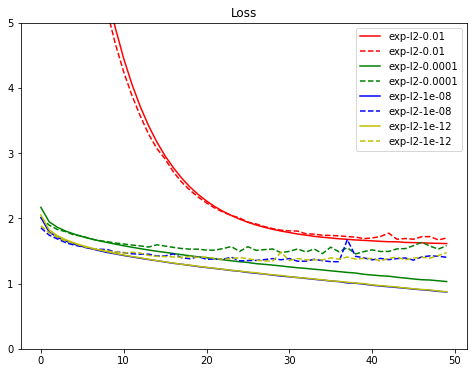

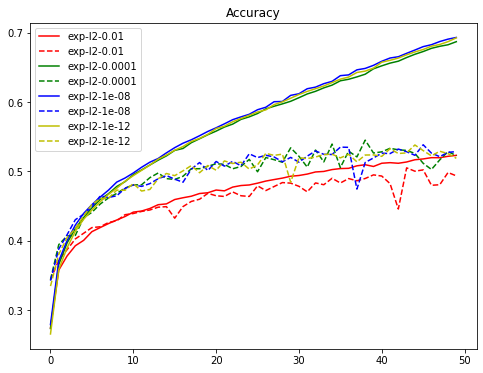

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果